In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 901.3/901.3 kB 23.2 MB/s eta 0:00:00


In [2]:
import shutil

source_folder = "/kaggle/input/cat-detection-and-segmentation/Cat/images"
destination_folder = "./Cat/images"
shutil.copytree(source_folder, destination_folder, dirs_exist_ok=True)

'./Cat/images'

In [3]:
import os
import cv2

def convert_masks_to_yolo(input_dir, output_dir, min_area=200, class_id=0):
    """
    Converts binary masks to YOLO label format for segmentation.

    Args:
        input_dir (str): The input directory where the binary masks are stored.
        output_dir (str): The output directory where YOLO labels are stored.
        min_area (int): Minimum contour area to process (default: 200).
        class_id (int): Object class ID for YOLO annotation (default: 0).

    Returns:
        None
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for mask_file in os.listdir(input_dir):
        image_path = os.path.join(input_dir, mask_file)

        # Load mask binary
        mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        _, mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)
        H, W = mask.shape

        # Find contours
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Process contours and create YOLO polygons
        polygons = []
        for cnt in contours:
            if cv2.contourArea(cnt) > min_area:
                polygon = []
                for point in cnt:
                    x, y = point[0]
                    polygon.append(x / W)
                    polygon.append(y / H)
                polygons.append(polygon)

        # Write YOLO labels
        label_file = os.path.join(output_dir, mask_file.replace('.png', '.txt'))
        with open(label_file, 'w') as f:
            for polygon in polygons:
                f.write(f"{class_id} " + " ".join(map(str, polygon)) + "\n")

    print(f"Conversion completed! Labels saved in '{output_dir}'")

In [4]:
ROOT_DIR = '/kaggle/input/cat-detection-and-segmentation/Cat'

In [5]:
convert_masks_to_yolo(input_dir=f'{ROOT_DIR}/masks/train', output_dir='./Cat/labels/train')
convert_masks_to_yolo(input_dir=f'{ROOT_DIR}/masks/val', output_dir='./Cat/labels/val')
convert_masks_to_yolo(input_dir=f'{ROOT_DIR}/masks/test', output_dir='./Cat/labels/test')

Conversion completed! Labels saved in './Cat/labels/train'
Conversion completed! Labels saved in './Cat/labels/val'
Conversion completed! Labels saved in './Cat/labels/test'


In [6]:
# Create the YAML file content as a string
yaml_content = f"""
path: /kaggle/working/Cat # dataset root dir
train: images/train
val: images/val 
test: images/test

names:
    0: Cat
"""

# Write the YAML content to a file
with open('data.yaml', 'w') as f:
  f.write(yaml_content)

print(f"Successfully created data.yaml")

Successfully created data.yaml


In [7]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11n-seg.pt")  # load a pretrained model

# Train the model
results = model.train(data="data.yaml", epochs=100, imgsz=640)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.90M/5.90M [00:00<00:00, 99.1MB/s]


Ultralytics 8.3.51 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=yolo11n-seg.pt, data=data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width

100%|██████████| 755k/755k [00:00<00:00, 25.1MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 113MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/Cat/labels/train... 1000 images, 40 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:01<00:00, 706.86it/s]


train: New cache created: /kaggle/working/Cat/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/Cat/labels/val... 100 images, 7 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 442.64it/s]

val: New cache created: /kaggle/working/Cat/labels/val.cache


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.07G      1.007      2.597      2.176      1.422         21        640: 100%|██████████| 63/63 [00:18<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]


                   all        100        132      0.589       0.39      0.445      0.233      0.533      0.348      0.371      0.185

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.02G      1.223      2.582      1.734      1.578         22        640: 100%|██████████| 63/63 [00:15<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.97it/s]

                   all        100        132      0.319      0.216      0.194     0.0701      0.271      0.182      0.112     0.0346



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.05G      1.354      2.807      1.672      1.655         30        640: 100%|██████████| 63/63 [00:14<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.22it/s]

                   all        100        132      0.269      0.485      0.261       0.11      0.291      0.342      0.199     0.0805



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100         3G      1.391       2.85       1.64       1.67         24        640: 100%|██████████| 63/63 [00:14<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.14it/s]

                   all        100        132      0.529      0.538      0.427      0.191      0.462       0.47      0.339      0.127



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.06G      1.338      2.808      1.561      1.629         30        640: 100%|██████████| 63/63 [00:14<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]

                   all        100        132      0.719      0.492      0.509      0.217      0.661      0.447      0.412      0.161



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.01G      1.341      2.857      1.572      1.661         18        640: 100%|██████████| 63/63 [00:15<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.33it/s]

                   all        100        132      0.679      0.592      0.535      0.283      0.654      0.583       0.53      0.263



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.02G      1.304      2.563      1.469      1.628         26        640: 100%|██████████| 63/63 [00:14<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.33it/s]

                   all        100        132      0.727      0.564      0.579      0.292       0.62       0.53      0.474      0.177



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.04G      1.266      2.644      1.396      1.574         24        640: 100%|██████████| 63/63 [00:15<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.38it/s]

                   all        100        132      0.813      0.624       0.64      0.392      0.779      0.583      0.597      0.357



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.04G      1.223      2.583      1.384      1.556         22        640: 100%|██████████| 63/63 [00:15<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]

                   all        100        132      0.824      0.583      0.623      0.424      0.803      0.568      0.601      0.377



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.07G      1.233      2.523      1.385      1.547         32        640: 100%|██████████| 63/63 [00:15<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.11it/s]

                   all        100        132      0.742      0.621      0.624      0.384      0.771      0.644      0.647      0.397



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.05G      1.191       2.47      1.288      1.522         30        640: 100%|██████████| 63/63 [00:15<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.35it/s]

                   all        100        132      0.649      0.583      0.508      0.236      0.621      0.508      0.424      0.214



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.02G      1.168       2.44      1.264      1.515         26        640: 100%|██████████| 63/63 [00:15<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.07it/s]

                   all        100        132      0.767      0.583      0.585      0.404      0.711       0.53      0.502      0.297



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.04G      1.156       2.46      1.257      1.503         22        640: 100%|██████████| 63/63 [00:15<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.05it/s]

                   all        100        132      0.766      0.629      0.655      0.423      0.756      0.621      0.646      0.394



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.07G      1.156      2.327      1.251      1.506         28        640: 100%|██████████| 63/63 [00:15<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.17it/s]

                   all        100        132      0.763      0.652      0.633      0.396      0.752      0.583      0.594      0.364



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.05G      1.141      2.371      1.211      1.495         31        640: 100%|██████████| 63/63 [00:15<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.14it/s]

                   all        100        132      0.669      0.552      0.531      0.302      0.626      0.462      0.427      0.238



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.02G      1.138      2.321      1.196      1.485         22        640: 100%|██████████| 63/63 [00:15<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.31it/s]

                   all        100        132      0.814      0.568      0.633      0.405      0.777      0.583      0.621      0.395



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.02G      1.073      2.342      1.186       1.45         20        640: 100%|██████████| 63/63 [00:15<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.07it/s]

                   all        100        132      0.817      0.644      0.611      0.426      0.769      0.606      0.556      0.355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.03G      1.073      2.245      1.129       1.44         36        640: 100%|██████████| 63/63 [00:15<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.26it/s]

                   all        100        132      0.808      0.644      0.651       0.42      0.808      0.644      0.646      0.403



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.03G      1.027      2.161      1.119      1.427         25        640: 100%|██████████| 63/63 [00:15<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.20it/s]

                   all        100        132      0.768      0.644      0.603      0.442      0.751      0.629      0.578      0.416



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.01G      1.077      2.174      1.152      1.444         25        640: 100%|██████████| 63/63 [00:15<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.24it/s]

                   all        100        132      0.679       0.61      0.584      0.342      0.646       0.58      0.547      0.318



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.98G      1.062      2.237       1.16      1.437         25        640: 100%|██████████| 63/63 [00:15<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.55it/s]

                   all        100        132      0.713      0.621      0.609      0.386      0.714      0.598      0.567      0.359



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.99G      1.113      2.238      1.167      1.473         28        640: 100%|██████████| 63/63 [00:15<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.49it/s]

                   all        100        132      0.801       0.61      0.654      0.458      0.772      0.591      0.603      0.396



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.03G      1.034      2.058      1.075      1.417         23        640: 100%|██████████| 63/63 [00:15<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.00it/s]

                   all        100        132      0.882      0.624      0.661      0.483      0.846      0.614      0.612      0.405



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.02G      1.017      2.036       1.06      1.405         22        640: 100%|██████████| 63/63 [00:15<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.15it/s]

                   all        100        132      0.823      0.636      0.655      0.441      0.774      0.598      0.589      0.356



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.99G      1.026       2.06      1.103      1.411         28        640: 100%|██████████| 63/63 [00:15<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.05it/s]

                   all        100        132       0.82      0.636      0.648      0.422      0.792      0.614      0.609      0.389



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.01G      1.042      2.146      1.109      1.408         25        640: 100%|██████████| 63/63 [00:15<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]

                   all        100        132      0.782      0.644      0.643      0.458      0.777      0.614      0.628      0.372



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.03G      1.023      2.073      1.114      1.395         25        640: 100%|██████████| 63/63 [00:15<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.49it/s]

                   all        100        132       0.78       0.67      0.662      0.471      0.753      0.647      0.632      0.458



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.02G     0.9766      1.997      1.068      1.378         26        640: 100%|██████████| 63/63 [00:15<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.59it/s]

                   all        100        132      0.787      0.614      0.647      0.473      0.785      0.621      0.646      0.456



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.03G     0.9754      2.095      1.075       1.36         21        640: 100%|██████████| 63/63 [00:15<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.31it/s]

                   all        100        132      0.824      0.636      0.604       0.43        0.8      0.636      0.588      0.419



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.01G     0.9833      1.944      1.031      1.384         32        640: 100%|██████████| 63/63 [00:15<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.21it/s]

                   all        100        132      0.752      0.643      0.646      0.465       0.73      0.636      0.621       0.44



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.03G      1.002      1.968      1.079      1.391         18        640: 100%|██████████| 63/63 [00:15<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.24it/s]

                   all        100        132      0.839      0.652      0.649      0.451      0.819      0.636       0.63      0.433



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.04G     0.9422      1.893     0.9817      1.348         28        640: 100%|██████████| 63/63 [00:15<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.09it/s]

                   all        100        132      0.857      0.652      0.606      0.411      0.817      0.621      0.572       0.33



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.01G     0.9381      1.931      1.006      1.346         21        640: 100%|██████████| 63/63 [00:15<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.39it/s]

                   all        100        132      0.836      0.619      0.683      0.477      0.825      0.636      0.683      0.469



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.01G      0.971      1.906      1.027      1.376         21        640: 100%|██████████| 63/63 [00:15<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.40it/s]

                   all        100        132      0.771      0.621      0.658       0.46      0.773      0.647      0.665      0.448



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.99G     0.9355      1.906     0.9873      1.353         19        640: 100%|██████████| 63/63 [00:15<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.23it/s]

                   all        100        132      0.832      0.644      0.679      0.512      0.812      0.629      0.656      0.482



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.04G     0.9161      1.832     0.9663      1.339         24        640: 100%|██████████| 63/63 [00:15<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.06it/s]

                   all        100        132      0.897      0.606      0.707      0.527      0.886      0.598      0.692      0.497



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.03G     0.9363      1.873     0.9885      1.339         24        640: 100%|██████████| 63/63 [00:15<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.39it/s]

                   all        100        132      0.867      0.643      0.636      0.473      0.826      0.614      0.588      0.442



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.99G     0.9538      1.875     0.9888      1.363         22        640: 100%|██████████| 63/63 [00:15<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.12it/s]

                   all        100        132      0.823      0.629      0.663       0.48      0.784      0.606      0.625      0.423



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.03G     0.8827      1.819       0.93       1.32         24        640: 100%|██████████| 63/63 [00:15<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.35it/s]

                   all        100        132      0.803      0.667      0.705       0.51      0.753      0.644      0.663      0.475



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.99G     0.8778      1.825     0.9429      1.307         29        640: 100%|██████████| 63/63 [00:15<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.40it/s]

                   all        100        132      0.829      0.621      0.648      0.463      0.814      0.598        0.6      0.406



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.03G     0.9016      1.855      0.963      1.333         26        640: 100%|██████████| 63/63 [00:15<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.28it/s]

                   all        100        132      0.848      0.652      0.659      0.477      0.829      0.636      0.636       0.46



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.99G     0.8773      1.808     0.9192      1.308         25        640: 100%|██████████| 63/63 [00:15<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.04it/s]

                   all        100        132       0.87      0.674      0.668      0.494       0.85      0.659       0.64      0.463



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.01G     0.8928      1.813     0.9325       1.32         23        640: 100%|██████████| 63/63 [00:15<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.41it/s]

                   all        100        132      0.847      0.659      0.678      0.503      0.828      0.644      0.652      0.491



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100         3G     0.8582       1.73     0.9053      1.279         25        640: 100%|██████████| 63/63 [00:15<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.37it/s]

                   all        100        132      0.857      0.644      0.685      0.523      0.837      0.629      0.661       0.47



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.02G     0.8612      1.742     0.9163        1.3         22        640: 100%|██████████| 63/63 [00:15<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.25it/s]

                   all        100        132      0.855      0.652      0.676      0.506      0.814      0.621      0.617      0.469



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.02G     0.8782      1.788     0.9067      1.305         24        640: 100%|██████████| 63/63 [00:15<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.42it/s]

                   all        100        132       0.84      0.652      0.638      0.476       0.82      0.636      0.628      0.453



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.03G     0.8666      1.719      0.929      1.309         27        640: 100%|██████████| 63/63 [00:15<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

                   all        100        132       0.84      0.652      0.703      0.525       0.82      0.636       0.68      0.507



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100         3G     0.8651      1.739     0.8828       1.28         26        640: 100%|██████████| 63/63 [00:15<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.09it/s]

                   all        100        132      0.834      0.649      0.675      0.525      0.815      0.634      0.642      0.489



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.01G     0.8497       1.72       0.91      1.275         25        640: 100%|██████████| 63/63 [00:15<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.96it/s]

                   all        100        132       0.91      0.613      0.713      0.543       0.81      0.629      0.689      0.491



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.01G     0.8837      1.732     0.9041      1.293         21        640: 100%|██████████| 63/63 [00:15<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.40it/s]

                   all        100        132      0.867      0.652      0.671      0.498      0.857      0.644      0.662      0.484



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.01G     0.8452       1.67        0.9      1.287         23        640: 100%|██████████| 63/63 [00:15<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.06it/s]

                   all        100        132      0.819      0.653      0.681      0.511       0.81      0.646      0.666      0.478



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.99G     0.8491      1.678     0.8884      1.283         34        640: 100%|██████████| 63/63 [00:15<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.27it/s]

                   all        100        132      0.858      0.629      0.695      0.517      0.847      0.621      0.677      0.517



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.01G     0.8513      1.677     0.8908      1.294         23        640: 100%|██████████| 63/63 [00:15<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.34it/s]

                   all        100        132      0.834      0.647      0.659      0.501      0.815      0.632      0.635      0.479



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.04G     0.7975      1.608     0.8417      1.261         23        640: 100%|██████████| 63/63 [00:15<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]

                   all        100        132      0.819      0.652      0.644      0.493      0.827      0.606      0.622      0.462



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.01G     0.8179      1.589     0.8386      1.274         23        640: 100%|██████████| 63/63 [00:15<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.72it/s]

                   all        100        132      0.837      0.663      0.718      0.552      0.828      0.656      0.718      0.537



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.02G     0.8329      1.633     0.8707      1.262         24        640: 100%|██████████| 63/63 [00:14<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.22it/s]

                   all        100        132      0.828      0.655      0.687      0.526      0.798      0.652      0.666      0.498



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.01G     0.8198      1.635     0.8437      1.258         24        640: 100%|██████████| 63/63 [00:15<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.30it/s]

                   all        100        132      0.867      0.667      0.709      0.558      0.857      0.659      0.696      0.517



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.02G     0.8061       1.63     0.8414      1.274         23        640: 100%|██████████| 63/63 [00:15<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.46it/s]

                   all        100        132      0.852      0.636      0.649      0.473       0.81      0.659       0.65      0.466



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.05G     0.8079      1.605     0.8505      1.246         27        640: 100%|██████████| 63/63 [00:15<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.98it/s]

                   all        100        132      0.866      0.644      0.662      0.524      0.847      0.614      0.626      0.481



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.02G     0.7904      1.569     0.8264      1.256         26        640: 100%|██████████| 63/63 [00:15<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.46it/s]

                   all        100        132      0.841      0.674      0.658      0.508      0.831      0.669      0.642      0.484



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.99G     0.8046      1.591     0.8136      1.251         21        640: 100%|██████████| 63/63 [00:15<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.30it/s]

                   all        100        132       0.85      0.645       0.68      0.543       0.84      0.638      0.677      0.516



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.01G     0.7992      1.544     0.8191      1.252         24        640: 100%|██████████| 63/63 [00:15<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.95it/s]

                   all        100        132      0.833       0.68      0.716       0.53      0.814      0.667      0.689      0.491



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.01G     0.7838      1.487     0.8093      1.242         24        640: 100%|██████████| 63/63 [00:15<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.40it/s]

                   all        100        132      0.873      0.644      0.664      0.511      0.852      0.629      0.638      0.476



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.02G     0.7823      1.545     0.7953      1.238         30        640: 100%|██████████| 63/63 [00:15<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.30it/s]

                   all        100        132      0.868      0.667      0.675      0.517      0.818      0.629      0.616      0.479



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.03G     0.7828      1.547     0.7909      1.248         25        640: 100%|██████████| 63/63 [00:15<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.46it/s]

                   all        100        132      0.876      0.644      0.697      0.547      0.871      0.636       0.69      0.508



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.01G      0.771      1.472     0.7856      1.234         23        640: 100%|██████████| 63/63 [00:14<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.01it/s]

                   all        100        132      0.848      0.659      0.666      0.516      0.838      0.652      0.648       0.48



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.03G     0.7778      1.502     0.7686      1.228         26        640: 100%|██████████| 63/63 [00:15<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.38it/s]

                   all        100        132      0.888      0.659      0.697       0.53      0.841      0.621      0.654      0.501



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.02G     0.7654      1.404     0.7551      1.239         18        640: 100%|██████████| 63/63 [00:15<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        100        132      0.866      0.667      0.701      0.538      0.836      0.644      0.656      0.506



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.03G     0.7678      1.447     0.7593      1.218         30        640: 100%|██████████| 63/63 [00:15<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]

                   all        100        132      0.844      0.656      0.686      0.528      0.834      0.648      0.678      0.506



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.99G     0.7527      1.406     0.7514      1.216         27        640: 100%|██████████| 63/63 [00:15<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.06it/s]

                   all        100        132      0.836      0.652      0.693      0.538      0.816      0.636      0.674      0.523



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.03G     0.7455      1.453     0.7706       1.21         25        640: 100%|██████████| 63/63 [00:15<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.56it/s]

                   all        100        132      0.791       0.72      0.708      0.572      0.783      0.712      0.707      0.539



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.04G     0.7509      1.458     0.7506      1.221         21        640: 100%|██████████| 63/63 [00:15<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.20it/s]

                   all        100        132      0.853      0.644      0.671      0.534      0.822      0.621       0.66      0.496



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.01G     0.7522      1.452     0.7626      1.219         18        640: 100%|██████████| 63/63 [00:15<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.72it/s]

                   all        100        132      0.853       0.66      0.668      0.529      0.843      0.653      0.665      0.504



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.03G      0.778      1.525     0.7859      1.223         19        640: 100%|██████████| 63/63 [00:15<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.21it/s]

                   all        100        132      0.863      0.636      0.682       0.55      0.863      0.636      0.683      0.511



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.01G     0.7224      1.425       0.75      1.198         29        640: 100%|██████████| 63/63 [00:14<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.95it/s]

                   all        100        132       0.87      0.667      0.683      0.535       0.86      0.659      0.674      0.518



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.99G      0.719      1.407     0.7352      1.197         24        640: 100%|██████████| 63/63 [00:15<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.23it/s]

                   all        100        132      0.864      0.644      0.666      0.533      0.773       0.67      0.651      0.509



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.04G      0.744      1.396     0.7433      1.214         27        640: 100%|██████████| 63/63 [00:15<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.13it/s]

                   all        100        132      0.865      0.682      0.677       0.53      0.845      0.667      0.664      0.518



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.01G     0.7264       1.33     0.7165      1.187         23        640: 100%|██████████| 63/63 [00:15<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.39it/s]

                   all        100        132      0.842      0.659      0.671      0.521      0.852      0.667      0.675      0.512



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.01G     0.7238      1.348     0.7189      1.192         23        640: 100%|██████████| 63/63 [00:15<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.52it/s]

                   all        100        132      0.812      0.652      0.674      0.548      0.812      0.652      0.674      0.536



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.02G     0.7379      1.416     0.7434      1.207         22        640: 100%|██████████| 63/63 [00:15<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.94it/s]

                   all        100        132       0.86       0.65      0.676      0.541      0.791      0.658      0.658      0.529



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.99G     0.7175      1.355      0.716      1.195         26        640: 100%|██████████| 63/63 [00:15<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.01it/s]

                   all        100        132      0.845      0.658      0.711      0.553       0.83      0.644      0.698       0.54



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.01G     0.7082      1.365     0.7145       1.19         22        640: 100%|██████████| 63/63 [00:15<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]

                   all        100        132      0.823      0.668      0.642      0.523      0.823      0.668      0.639        0.5



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.09G     0.7015      1.256     0.6827      1.182         27        640: 100%|██████████| 63/63 [00:15<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.58it/s]

                   all        100        132      0.829      0.661      0.684      0.544       0.81      0.647      0.669      0.532



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.07G     0.7096      1.323     0.7051       1.19         37        640: 100%|██████████| 63/63 [00:15<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.44it/s]

                   all        100        132      0.809      0.652      0.672      0.541      0.828      0.667       0.68      0.526



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.99G     0.6907      1.327     0.6938      1.181         25        640: 100%|██████████| 63/63 [00:15<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.08it/s]

                   all        100        132      0.819      0.667      0.704      0.555      0.819      0.667      0.696      0.538



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.03G     0.6813      1.294     0.6901      1.172         35        640: 100%|██████████| 63/63 [00:15<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.16it/s]

                   all        100        132      0.813      0.674      0.698      0.553      0.813      0.674        0.7      0.547



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.02G      0.671      1.286     0.6836      1.164         22        640: 100%|██████████| 63/63 [00:15<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.28it/s]

                   all        100        132      0.829      0.652      0.706      0.576       0.82      0.644      0.695      0.546



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100         3G     0.6761      1.272     0.6668      1.168         27        640: 100%|██████████| 63/63 [00:15<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.44it/s]

                   all        100        132      0.831      0.682      0.709      0.559      0.812      0.667      0.672      0.525



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.01G     0.6898      1.284     0.6739      1.173         21        640: 100%|██████████| 63/63 [00:15<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.50it/s]

                   all        100        132      0.823      0.674      0.675      0.549      0.804      0.659      0.657       0.52



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.02G     0.6744      1.259     0.6717      1.166         29        640: 100%|██████████| 63/63 [00:14<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

                   all        100        132      0.838      0.659      0.681       0.55      0.844      0.652      0.675      0.534


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.94G     0.5451      1.054     0.6091      1.115          9        640: 100%|██████████| 63/63 [00:16<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.43it/s]

                   all        100        132      0.835      0.652      0.652      0.535      0.825      0.644      0.642      0.512



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100         3G     0.4916     0.9985     0.5014      1.055          7        640: 100%|██████████| 63/63 [00:14<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]

                   all        100        132       0.87      0.659      0.672      0.548      0.841      0.644      0.639      0.521



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100         3G     0.4821     0.9829     0.4829      1.053          7        640: 100%|██████████| 63/63 [00:14<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.47it/s]

                   all        100        132      0.822      0.663      0.676      0.557      0.812      0.656      0.665      0.523



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100      3.02G     0.4895      1.005     0.4938      1.057         10        640: 100%|██████████| 63/63 [00:14<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.38it/s]

                   all        100        132      0.862      0.636      0.688      0.563      0.863      0.636      0.684      0.542



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.94G     0.4736     0.9202     0.4648      1.051          9        640: 100%|██████████| 63/63 [00:14<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.36it/s]

                   all        100        132      0.863      0.665      0.691       0.57      0.843       0.65      0.667      0.538



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100      3.01G     0.4567     0.9374      0.462      1.041          9        640: 100%|██████████| 63/63 [00:14<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.50it/s]

                   all        100        132      0.848      0.652      0.673      0.557      0.837      0.644      0.663      0.531



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100         3G     0.4646     0.9198     0.4562      1.032         10        640: 100%|██████████| 63/63 [00:14<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.64it/s]

                   all        100        132      0.851      0.667      0.677      0.559      0.827      0.653      0.666      0.528



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.98G     0.4392      0.975     0.4193      1.021          9        640: 100%|██████████| 63/63 [00:14<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.64it/s]

                   all        100        132       0.84      0.674      0.679      0.563      0.811      0.652      0.646      0.524



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100         3G     0.4479     0.9235      0.442      1.028          7        640: 100%|██████████| 63/63 [00:14<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.63it/s]

                   all        100        132      0.873      0.629      0.684      0.565      0.805      0.636      0.661      0.534



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.95G     0.4395      0.893     0.4171      1.015          8        640: 100%|██████████| 63/63 [00:14<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.69it/s]

                   all        100        132      0.841      0.667      0.687      0.572      0.822      0.652      0.666      0.537



100 epochs completed in 0.472 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train/weights/best.pt, 6.0MB

Validating runs/segment/train/weights/best.pt...
Ultralytics 8.3.51 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-seg summary (fused): 265 layers, 2,834,763 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


                   all        100        132      0.828      0.656      0.706      0.576      0.818      0.648      0.695      0.543
Speed: 0.2ms preprocess, 3.4ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/segment/train



image 1/1 /kaggle/input/cat-detection-and-segmentation/Cat/images/test/00567dcce4a5f7d9.jpg: 480x640 1 Cat, 98.8ms
Speed: 3.3ms preprocess, 98.8ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 640)


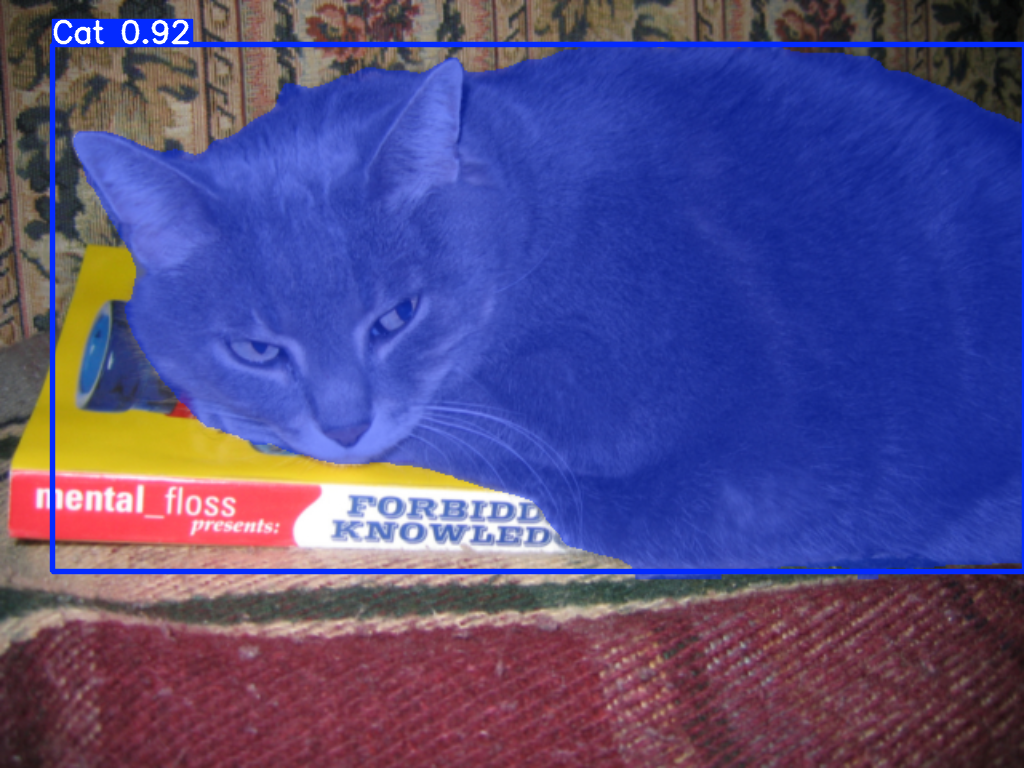

In [8]:
results = model("/kaggle/input/cat-detection-and-segmentation/Cat/images/test/00567dcce4a5f7d9.jpg")
results[0].show()